# Марковский процесс принятия решений

#### Дедлайн (жёсткий) задания: 31 марта, 23:59 UTC+3

#### При сдаче задания нужно данный файл и mdp.py поместить в архив, и послать архив в систему сдачи.

### <span style="color: red"> Если работа была списана и/или сделана LLM, то за работу ставится 0 баллов </span>. 

В данной работе рассматриваются методы, разработанные для решения Марковских процессов принятия решений, **M**arkov **D**ecision **P**rocesses, **MDP**. В самом широком смысле, MDP определяется тем, как он изменяет состояния и как вычисляются награды.

Переход состояний определяется распределением $P(s' |s,a)$ &mdash; насколько вероятно перейти в состояние $s'$, если производится действие $a$ в состоянии $s$. Существует несколько способов определить функцию вознаграждений, однако ради удобства будет использована следующая сигнатура: $r(s,a,s')$.

_Данный ноутбук вдохновлён заданием из курса_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _от Калифорнийского университета в Беркли_

# Работа выполнена: Вицын Семён Сергеевич, Б05-131.
# Теор задачи не делал :(

# Упражнения <span style="color: green">  (вплоть до 2 баллов + 2 балла дополнительно) </span>

## **Постановка задачи**  
Рассмотрим оператор $T: \mathbb{R}^{|\mathbb{S}|} \rightarrow \mathbb{R}^{|\mathbb{S}|}$
$$
(T V)(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V(s')],
$$ являющийся сжимающим отображением в норме $\|\cdot\|_\infty$.  
Алгоритм **Value Iteration (VI)** порождает последовательность итераций:  
$$
V_0 \in \mathbb{R}^n, \quad V_{t+1} = T(V_t), \quad \forall t \geq 0.
$$  
Необходимо доказать следующие утверждения.  


## Упражнение 1. Оценка ошибки и сходимости <span style="color: green"> (1 балл) </span>
Докажите, что из неравенства:
$$
\| V_s - V_{s+1} \|_\infty \leq \epsilon (1 - \gamma)(2\gamma)^{-1}
$$
следует, что:
$$
\| V^{\pi_s} - V^* \|_\infty \leq \epsilon.
$$

## Упражнение 2. Неравенства на оператор $T$ <span style="color: green"> (1 балл) </span>
Докажите, что для любого $v, w \in \mathbb{R}^n$ выполняются следующие неравенства:

1. **Сильная монотонность оператора $ I - T $**:
   $$
   (1 - \gamma) \cdot \| v - w \|_\infty \leq \| (I - T)(v) - (I - T)(w) \|_\infty.
   $$
   
2. **Липшицевость (гладкость) оператора $ I - T $**:
   $$
   \| (I - T)(v) - (I - T)(w) \|_\infty \leq (1 + \gamma) \cdot \| v - w \|_\infty.
   $$

Тут $I$ - тождественный оператор. Эти неравенства аналогичны условиям $\mu$-сильной выпуклости и $L$-Липшицевости градиента для гладких выпуклых функций.

##  Дополнительное упражнение 3. Оценка вычислительной сложности <span style="color: green"> (2 балла) </span>
Докажите, что для получения $\epsilon$-оптимальной политики $\pi$ (то есть такой, что $\| V^\pi - V^* \|_\infty \leq \epsilon$),  
алгоритму Value Iteration требуется выполнить:
$$
O\left( (1 - \gamma)^{-1} \log(\epsilon^{-1} (1 - \gamma)^{-1}) \right)
$$
итераций. 

# Итерационная оптимизация ценности, Value Iteration <span style="color: green"> (вплоть до 2 баллов) </span>


In [1]:
import numpy as np
from numpy import random
from time import sleep
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
%matplotlib inline

from mdp import MDP, FrozenLakeEnv, has_graphviz, plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values

Для начала, давайте определим простой MDP, изображённый на рисунке ниже:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [2]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

Теперь можно использовать MDP как и другие среды от Open AI Gym:

In [3]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


но также есть и другие методы, необходимые для имплементации алгоритма итерацонной оптимизации ценности (Value Iteration)

In [4]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ",
      mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Опционально: визуализация MDP

Вы можете визуализировать MDP с помощью функции отрисовки, написанной [neer201](https://github.com/neer201).

Для этого требуется установить graphviz системно и для Python. На Unix-подобных системах (Ubuntu) для этого достатчно выполнить следующие команды:

1. `sudo apt-get install graphviz`
2. `pip install graphviz`
3. перезагрузить этот ноутбук

__Замечание:__ Установка graphviz на некоторые ОС (особенно Windows) может быть нетривиальной. Поэтому можно пропусить данный шаг и использовать стандартную визуализацию.

In [5]:
print("Graphviz доступен:", has_graphviz)

Graphviz доступен: True


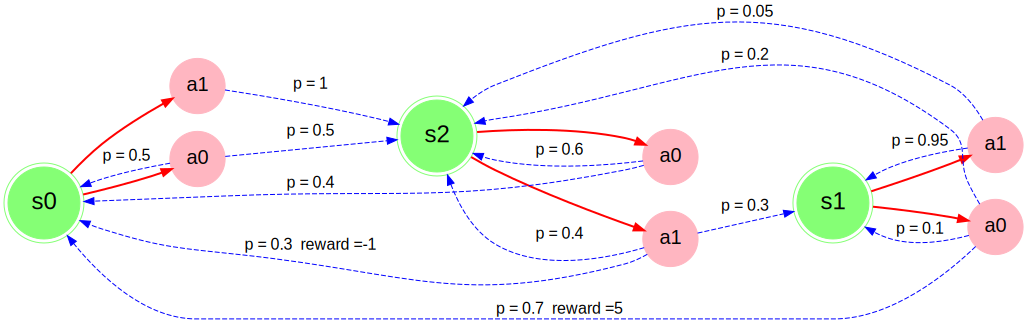

In [6]:
if has_graphviz:
    display(plot_graph(mdp))

Теперь построим первый способ решения MDP. Простейший на данный момент алгоритм называется итерационной оптимизацией ценности или __V__alue __I__teration

Ниже представлен псевдокод VI:

---

`1.` Инициализация $V^{(0)}(s)=0$, for all $s$

`2.` Для $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, для всех $s$

---

Для начала выпишем функцию вычисления $Q$-функции ценности $Q^{\pi}$, определив следующим образом

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [7]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Вычисляет Q(s,a) согласно формуле выше """

    return np.sum([prob * (mdp.get_reward(state, action, new_state) + gamma * state_values[new_state]) 
                   for new_state, prob in mdp.get_next_states(state, action).items()])

In [8]:
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Используя $Q(s,a)$ можно определить "следующее" $V(s)$ для итерационной оптимизации ценности.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [9]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Вычисляет следующее V(s) согласно формуле выше. Просьба не изменять state_values в процессе. """
    if mdp.is_terminal(state):
        return 0
    
    q_values = [np.sum([prob * (mdp.get_reward(state, action, new_state) + gamma * state_values[new_state])
                for new_state, prob in mdp.get_next_states(state, action).items()]) for action in mdp.get_possible_actions(state)]
    
    new_state_value = np.max(q_values)

    return new_state_value

In [10]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert test_Vs == test_Vs_copy, "просьба не изменять state_values в get_new_state_value"

Наконец-то можно скомбинировать написанное в работающий алгоритм.

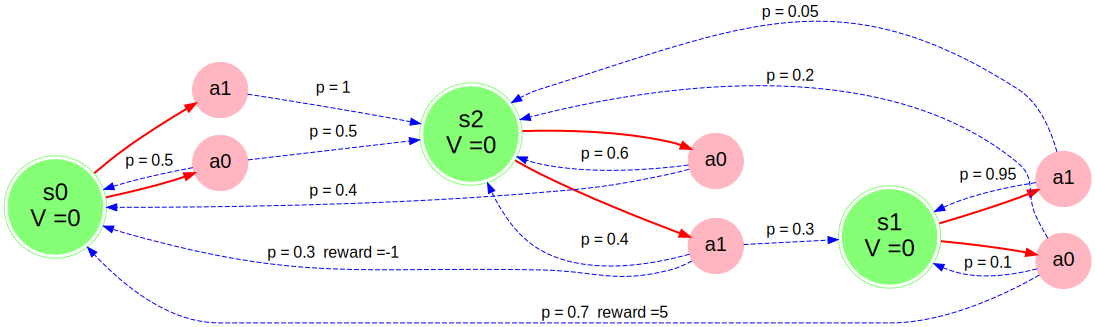

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.19277

In [11]:
%%time

# гиперпараметры
gamma = 0.9            # фактор дисконтирования MDP
num_iter = 100         # максимальное количество итераций, не включая инициализацию
# останов VI, если новые значения V(s) настолько близки к старым (или ближе)
min_difference = 0.001

# инициализация V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Вычисление новых V(s) используя определённые выше функции.
    # Должен быть словарь {state : float V_new(state)}
    new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)

    # Вычисление темпоральных различий V(s)
    diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
    print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Останов")
        break

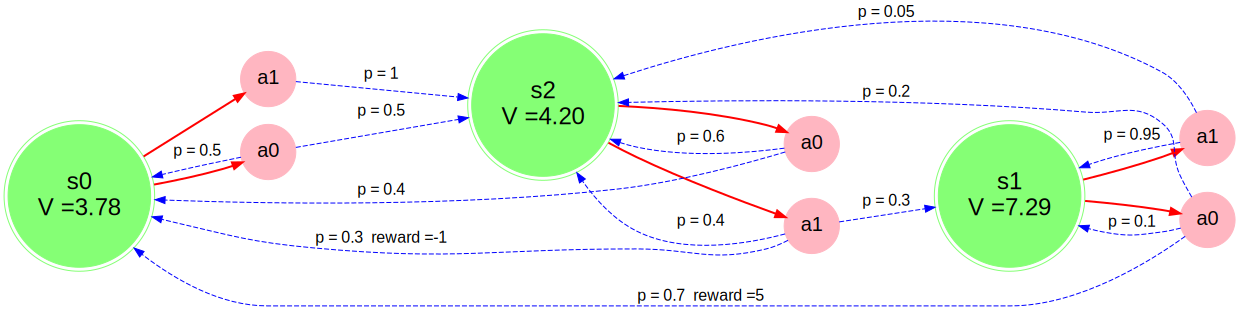

In [12]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [13]:
print("Финальные ценности состояний:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Финальные ценности состояний: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Теперь используем полученные $V^{*}(s)$ для определения оптимальных действий в каждом состоянии

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
Единственное отличие по сравнению с вычислением `V(s)` состоит в извлечении не `max`, а `argmax`: поиск действия с максимальной ценностью `Q(s,a)`.

In [14]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Выбор оптимального действия, используя формулу выше. """
    if mdp.is_terminal(state):
        return None
    
    q_values = [np.sum([prob * (mdp.get_reward(state, action, new_state) + gamma * state_values[new_state])
                for new_state, prob in mdp.get_next_states(state, action).items()]) for action in mdp.get_possible_actions(state)]
    
    optimal_action = np.argmax(q_values)

    return mdp.get_possible_actions(state)[optimal_action]

In [15]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

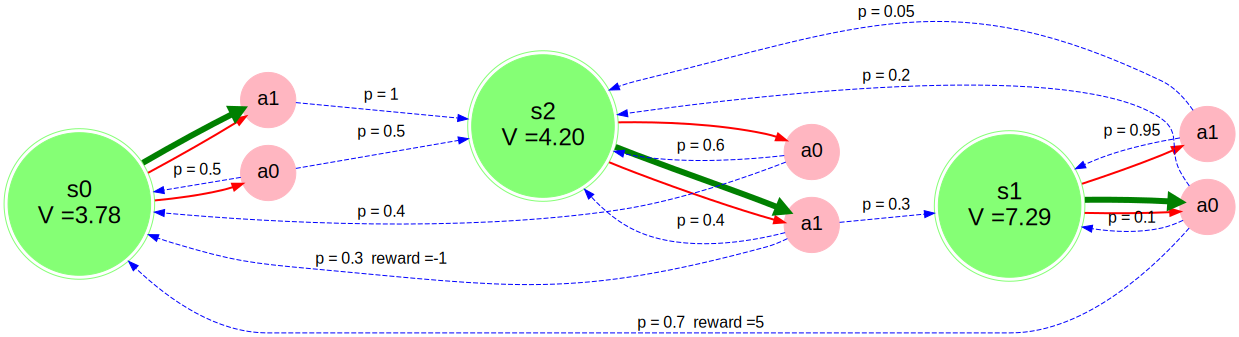

In [16]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values))

In [17]:
%%time

# Оценка средней награды агента

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("средняя награда: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

средняя награда:  0.4374
CPU times: user 416 ms, sys: 17.1 ms, total: 433 ms
Wall time: 419 ms


# Ускоренная итерационная оптимизация ценности, Momentum Value Iteration <span style="color: green"> (до 2 баллов) </span>

Аналогично оптимизации, в RL также есть различные техники ускорения поиска решения (оптимума). Momentum Value Iteration - один из них (см. [тут](https://arxiv.org/pdf/1905.09963)).  

---

**Algorithm M-VI:**

**Input:**  
- Начальные значения $ v_0 $, $v_1 = T(v^{(0)}) \in \mathbb{R}^{|\mathbf{S}|} $  
- Шаги спуска $ (\alpha_t)_{t \geq 0} $  
- Коэффициенты момента $ (\beta_t)_{t \geq 0} $ 

**For** $ t = 1, 2, 3, \dots $ **do**  
1. Обновляем значения:  
   $
   v_{t+1} = v_t - \alpha_s (v_t - T(v_t)) + \beta_s \cdot (v_t - v_{t-1})
   $  
**End For**

---

In [18]:
#имплементируйте шаг алгоритма
def momentum_step(mdp, prev_state_values, curr_state_values, state, gamma, alpha, beta):
    
    #примените оператор Беллмана к v_t
    T_v = get_new_state_value(mdp, curr_state_values, state, gamma)
    
    #реализуйте шаг алгоритма
    v_next = curr_state_values[state] - alpha * (curr_state_values[state] - T_v) + \
                                        beta * (curr_state_values[state] - prev_state_values[state])
    return v_next

## Hard instance MDP
Существует класс так называемых hard instance MDPs - MDP, решение уравнения Беллмана для которых сложно найти с хорошей точностью. Один из них - ForestMDP

In [19]:
transition_probs = {}

n = 5  # Example value for the maximum forest age
p = 0.05  # Probability of wildfire

transition_probs['s0'] = {'wait': {'s1': 1.0}, 'cut_sell': {'s1': 1.0}}

for i in range(1, n):
    transition_probs[f's{i}'] = {
        'wait': {f's{i+1}': 1 - p, 's1': p},
        'cut_sell': {'s1': 1.0}
    }

# Last state (forest cannot grow beyond n)
transition_probs[f's{n}'] = {
    'wait': {f's{n}': 1 - p, 's1': p},
    'cut_sell': {'s1': 1.0}
}

rewards = {}

rewards['s0'] = {'wait': {'s1': 0}, 'cut_sell': {'s1': 0}}

for i in range(1, n):
    rewards[f's{i}'] = {
        'wait': {f's{i+1}': 0, 's1': 0},
        'cut_sell': {'s1': 1 if i < n else 2}
    }

# Last state has a reward for waiting
rewards[f's{n}'] = {
    'wait': {f's{n}': 4, 's1': 0},
    'cut_sell': {'s1': 2}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

Постройте графики сравнений сходимости алгоритмов обычного Value Iteration и Momentum Value Iteration в терминах числа итераций, а также затрачиваемого времени на их работу при разных значениях $\gamma$. В качестве критерия сходимости используйте $\|V_{t+1} - V_t\|_{\infty}$. Является ли эта зависимость монотонной? Сделайте выводы

Value Iteration

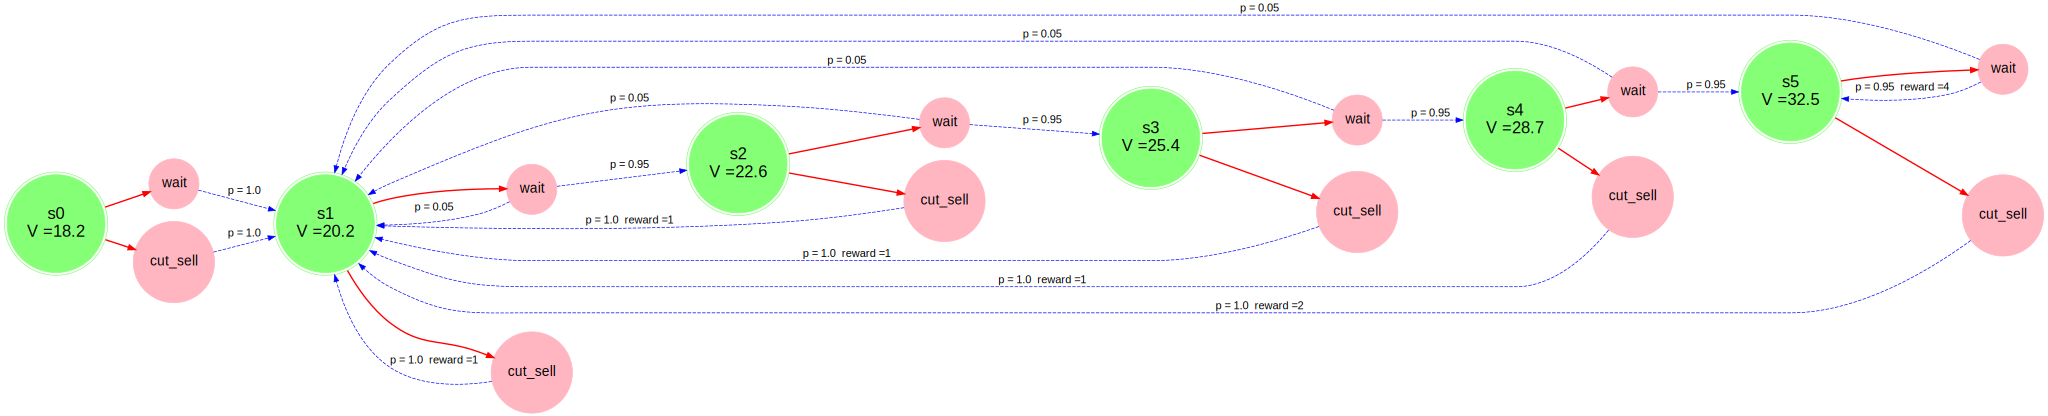

In [42]:
import time

# гиперпараметры
gammas = [0.8, 0.85, 0.9, 0.95, 0.99]
num_iter = 200
min_difference = 0.001


def value_iteration_experiments(gammas, num_iter, min_difference):
    iter_result = []
    time_result = []
    diff_history = []

    for gamma in gammas:
        start_time = time.time()
        state_values = {s: 0 for s in mdp.get_all_states()}
        history = []

        for iter in range(num_iter):
            new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}
            assert isinstance(new_state_values, dict)

            diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
            history.append(diff)

            state_values = new_state_values

            if diff < min_difference:
                break
        
        total_time = time.time() - start_time

        if gamma == 0.9:
            diff_history = history
            if has_graphviz:
                display(plot_graph_with_state_values(mdp, state_values))

        iter_result.append(iter)
        time_result.append(total_time)

    return iter_result, time_result, diff_history

VI_iter, VI_time, VI_diff_history = value_iteration_experiments(gammas, num_iter, min_difference)

Momentum value iteration

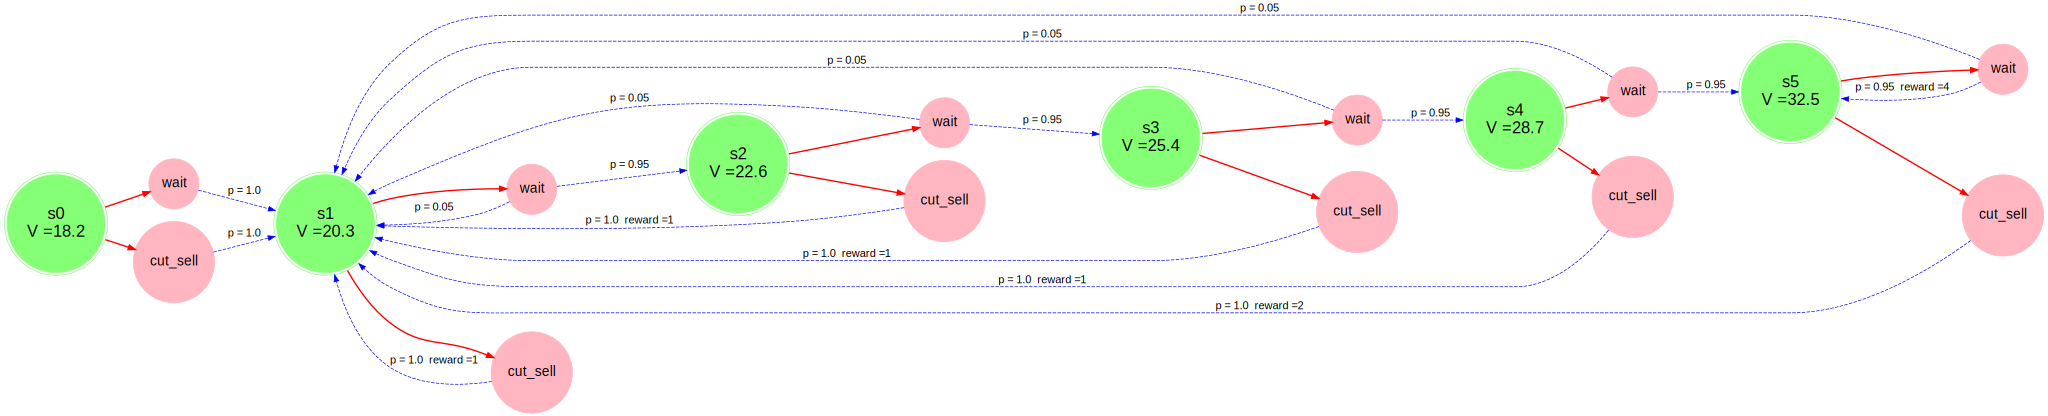

In [43]:
alpha = 1
beta = 0.5


def momentum_value_iteration_experiments(gammas, num_iter, min_difference, alpha, beta):
    iter_result = []
    time_result = []
    diff_history = []

    for gamma in gammas:
        start_time = time.time()
        prev_state_values = {s: 0 for s in mdp.get_all_states()}
        state_values = {s: 0 for s in mdp.get_all_states()}
        history = []

        for iter in range(num_iter):
            new_state_values = {state: momentum_step(mdp, prev_state_values, state_values, state, gamma, alpha, beta) for state in mdp.get_all_states()}
            assert isinstance(new_state_values, dict)

            diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
            history.append(diff)

            prev_state_values = state_values
            state_values = new_state_values

            if diff < min_difference:
                break
        
        total_time = time.time() - start_time

        if gamma == 0.9:
            diff_history = history
            if has_graphviz:
                display(plot_graph_with_state_values(mdp, state_values))

        iter_result.append(iter)
        time_result.append(total_time)

    return iter_result, time_result, diff_history

MVI_iter, MVI_time, MVI_diff_history = momentum_value_iteration_experiments(gammas, num_iter, min_difference, alpha, beta)

Сomparison

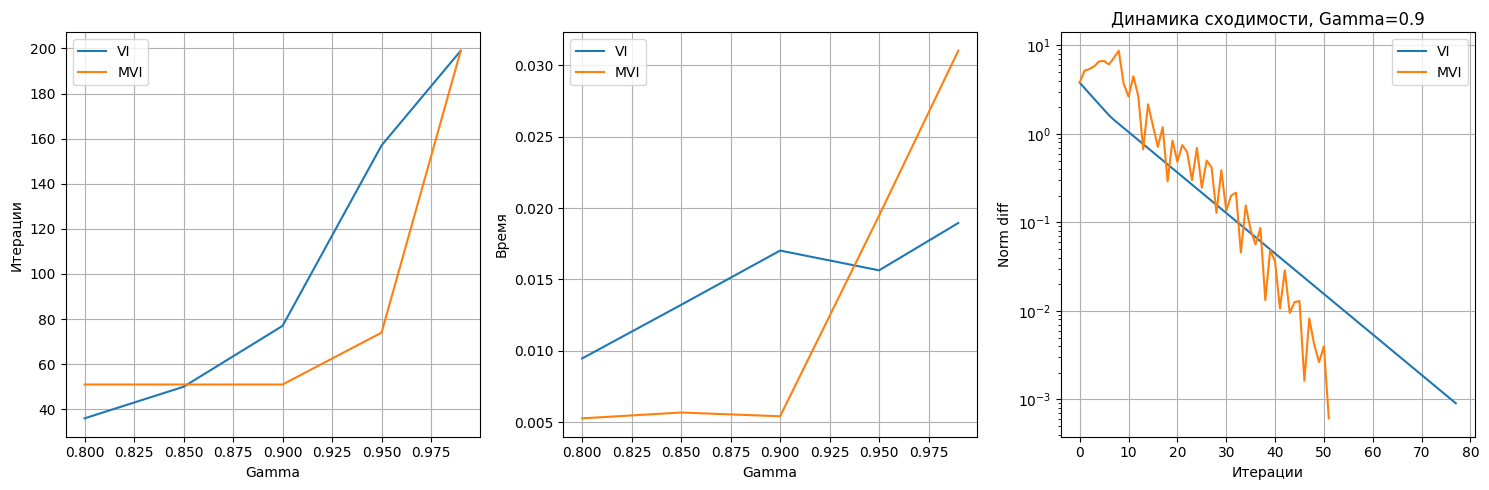

In [45]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(gammas, VI_iter, label='VI')
plt.plot(gammas, MVI_iter, label='MVI')
plt.xlabel('Gamma')
plt.ylabel('Итерации')
plt.grid(True)
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(gammas, VI_time, label='VI')
plt.plot(gammas, MVI_time, label='MVI')
plt.xlabel('Gamma')
plt.ylabel('Время')
plt.grid(True)
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(VI_diff_history, label='VI')
plt.plot(MVI_diff_history, label='MVI')
plt.xlabel('Итерации')
plt.ylabel('Norm diff')
plt.title('Динамика сходимости, Gamma=0.9')
plt.yscale('log')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Выводы:

- При оптимальных параматрах MVI сходится быстрее VI.
- При равно количестве итераций (gamma=0.99) MVI работает дольше, чем VI. Следует из того, что MVI делает больше вычислений для одной итерации.
- Сходимость у MVI более шумная, но более быстрая.

### Frozen lake

In [46]:
mdp = FrozenLakeEnv(slip_chance=0)
mdp.render()

*FFF
FHFH
FFFH
HFFG



In [47]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5, verbose=True):
    """ Выполняет num_iter шагов итерационной оптимизации ценности, начиная с state_values.
         То же, что и ранее, но в формате функции """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Вычислить новые ценности состояний, используя определённые выше функции.
        # В результате должен получиться словарь формата {state : new_V(state)}
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}

        assert isinstance(new_state_values, dict)

        # Вычислить темпоральную разность по значениям ценности
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())
        
        if verbose:
            print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   V(start): %.3f " %
                  (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [48]:
%%time

state_values = value_iteration(mdp)

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
CPU times: user 6.93 ms, sys: 0 ns, total: 6.93 ms
Wall time: 6.57 ms


In [49]:
%%time

s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    print(mdp.get_possible_actions(s))
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

('left', 'down', 'right', 'up')
SFFF
*HFH
FFFH
HFFG

down

('left', 'down', 'right', 'up')
SFFF
FHFH
*FFH
HFFG

right

('left', 'down', 'right', 'up')
SFFF
FHFH
F*FH
HFFG

down

('left', 'down', 'right', 'up')
SFFF
FHFH
FFFH
H*FG

right

('left', 'down', 'right', 'up')
SFFF
FHFH
FFFH
HF*G

right

('left', 'down', 'right', 'up')
SFFF
FHFH
FFFH
HFF*

CPU times: user 2.98 ms, sys: 55 µs, total: 3.03 ms
Wall time: 2.48 ms


### Время визуализаций!

Обычно полезно и интересно видеть, что в действительности Ваш алгоритм выучивает под капотом. Для этого можно изобразить V-функцию и оптимальные действия на каждом шаге алгоритма VI.

In [50]:
def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (-1, 0)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 


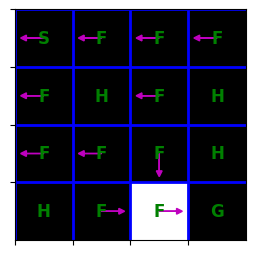

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 


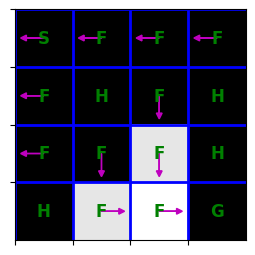

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 


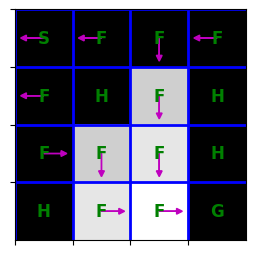

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 


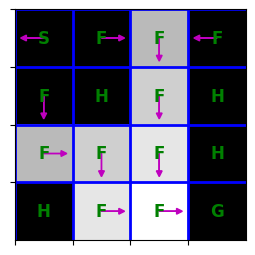

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 


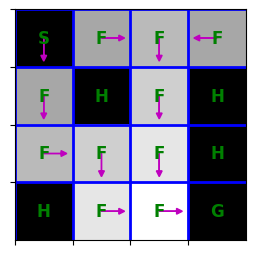

после итерации 5
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 


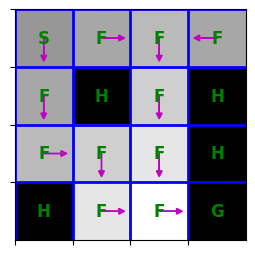

после итерации 6
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


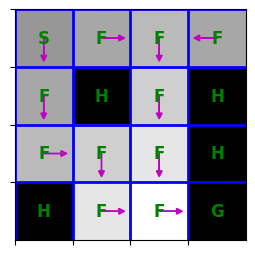

после итерации 7
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


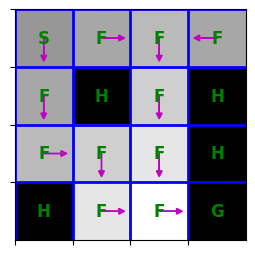

после итерации 8
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


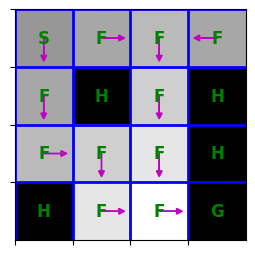

после итерации 9
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 


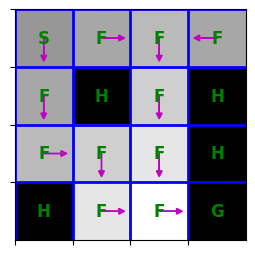

CPU times: user 916 ms, sys: 1.14 s, total: 2.06 s
Wall time: 732 ms


In [51]:
%%time

state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 29
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.198 


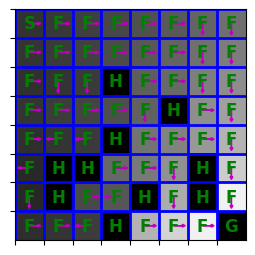

CPU times: user 5.64 s, sys: 4.82 s, total: 10.5 s
Wall time: 19.8 s


In [52]:
%%time

mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

Массовые испытания

In [53]:
%%time

mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Отлинчая работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 1.00000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.81000   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.65610   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.59049   |   V(start): 0.590 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.00000   |   V(start): 0.590 
средняя награда:  1.0
Отлинчая работа!
CPU times: user 419 ms, sys: 173 ms, total: 592 ms
Wall time: 484 ms


In [54]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.90000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.72900   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.62330   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.50487   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.40894   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.34868   |   V(start): 0.349 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.06529   |   V(start): 0.410 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.05832   |   V(start): 0.468 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.01139   |   V(start): 0.480 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.00764   |   V(start): 0.487 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00164   |   V(start): 0.489 
Итерация   11   |   разность max

In [55]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.75000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.50625   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.39867   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.26910   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.18164   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.14013   |   V(start): 0.140 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.07028   |   V(start): 0.199 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.06030   |   V(start): 0.260 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.02594   |   V(start): 0.285 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.01918   |   V(start): 0.305 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.00858   |   V(start): 0.313 
Итерация   11   |   разность max

In [56]:
%%time

# Оценка средней награды агента
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("средняя награда: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Отличная работа!")

Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.80000   |   V(start): 0.000 
Итерация    1   |   разность max_s|V_new(s) - V_old(s)|: 0.57600   |   V(start): 0.000 
Итерация    2   |   разность max_s|V_new(s) - V_old(s)|: 0.41472   |   V(start): 0.000 
Итерация    3   |   разность max_s|V_new(s) - V_old(s)|: 0.29860   |   V(start): 0.000 
Итерация    4   |   разность max_s|V_new(s) - V_old(s)|: 0.24186   |   V(start): 0.000 
Итерация    5   |   разность max_s|V_new(s) - V_old(s)|: 0.19349   |   V(start): 0.000 
Итерация    6   |   разность max_s|V_new(s) - V_old(s)|: 0.15325   |   V(start): 0.000 
Итерация    7   |   разность max_s|V_new(s) - V_old(s)|: 0.12288   |   V(start): 0.000 
Итерация    8   |   разность max_s|V_new(s) - V_old(s)|: 0.09930   |   V(start): 0.000 
Итерация    9   |   разность max_s|V_new(s) - V_old(s)|: 0.08037   |   V(start): 0.000 
Итерация   10   |   разность max_s|V_new(s) - V_old(s)|: 0.06426   |   V(start): 0.000 
Итерация   11   |   разность max

# Итерационная оптимизация политики, Policy Iteration <span style="color: green"> (до 2 баллов) </span>

Требуется имплементировать явную итерационную оптимизацию политики, Policy Iteration (PI) согласно следующему псевдокоду:

---
Инициализация $\pi_0$   `// случайная или константная`

Для $n=0, 1, 2, \dots$
- Вычислить функцию $V^{\pi_{n}}$
- С помощью $V^{\pi_{n}}$, вычислить функцию $Q^{\pi_{n}}$
- Вычислить новую политику $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

В отличие от VI, Policy Iteration требует явное вычисление политики &mdash; выбранное действие для каждого состояния &mdash; и оценку $V^{\pi_{n}}$ на основе данной политики. Обновление политики происходит после (итеративного) вычисления V-функции.


Ниже представлены несколько функций-помощников, которые могут оказаться полезными при имплементации методов.

In [71]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

Настало время написать функцию под названием `compute_vpi`, которая вычисляет функцию $V^{\pi}$ для произвольной политики $\pi$.

В отличие от VI, в этот раз требуется точное решение, не просто одна итерация.

Напоминаем, что $V^{\pi}$ удовлетворяет следующему линейному соотношению:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

Вам потребуется решить систему линейных алгебраических уравнений в коде. (Найдите точное решение, например, С помощью `np.linalg.solve` или метода простых итераций.)

In [72]:
def compute_vpi(mdp, policy, gamma):
    """
    Вычисляет V^pi(s) ДЛЯ ВСЕХ СОСТОЯНИЙ при текущей политике.
    :параметр policy: словарь выбранных на данный момент действий {s : a}
    :возвращает: словарь {state : V^pi(state) для всех state}
    """
    states = mdp.get_all_states()
    state_idx = {s: i for i, s in enumerate(states)}

    A = np.identity(len(states))
    r = np.zeros(len(states))

    for s in states:
        i = state_idx[s]
        a = policy[s]
        if mdp.is_terminal(s):
            continue

        for new_s, prob in mdp.get_next_states(s, a).items():
            j = state_idx[new_s]
            A[i][j] -= gamma * prob
            r[i] += prob * mdp.get_reward(s, a, new_s)


    v = np.linalg.solve(A, r)
    
    return {s: v[i] for i, s in enumerate(states)}

In [78]:
%%time

test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print(new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi должен возвращать словарь {state : V^pi(state) для всех state}"

{'s0': 3.789948615114679, 's1': 7.3029201654342675, 's2': 4.211054016794088}
CPU times: user 428 µs, sys: 0 ns, total: 428 µs
Wall time: 368 µs


Как только получены новые ценности состояний, время обновить текущую политику.

In [79]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Вычисляет жадно новую политику как argmax по функции ценности
    :параметр vpi: словарь {state : V^pi(state) для всех state}
    :возвращает: словарь {state : оптимальное действие для всех state}
    """

    return {state: get_optimal_action(mdp, vpi, state, gamma) for state in mdp.get_all_states()}

In [80]:
%%time

new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy должен возвращать словарь {состояние : оптимальное действие}"

{'s0': 'a1', 's1': 'a0', 's2': 'a1'}
CPU times: user 1.09 ms, sys: 39 µs, total: 1.13 ms
Wall time: 885 µs


__Основной цикл__

In [82]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Запуск итерационной оптимизации политики в цикле на num_iter итераций, или пока max_s|V_new(s) - V_old(s)|
    не станет меньше min_difference. Если начальная политика не дана, то инициализация случайная.
    """
    if policy is None:
        policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states()}

    state_values = compute_vpi(mdp, policy, gamma)


    for i in range(num_iter):
        policy = compute_new_policy(mdp, state_values, gamma)
        new_state_values = compute_vpi(mdp, policy, gamma)

        diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
        print("Итерация %4i   |   разность max_s|V_new(s) - V_old(s)|: %6.5f   |   " % (i, diff), end="")
        print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
        state_values = new_state_values

        if diff < min_difference:
            print("Останов")
            break
            
    return state_values, policy

__Ваши результаты экспериментирования с PI__

Сравнение PI и VI на различных MDP (FrozenLake, варьируя slip_chance), на малом и большом FrozenLake

In [87]:
slip_chances = [0.1, 0.2, 0.3, 0.4, 0.5]
small_mdp = []
big_mdp = []

for slip_chance in slip_chances:
    small_env = FrozenLakeEnv(map_name='4x4', slip_chance=slip_chance)
    big_env = FrozenLakeEnv(map_name='8x8', slip_chance=slip_chance)
    small_mdp.append(small_env)
    big_mdp.append(big_env)

In [93]:
import time


def value_iteration_frozen_lake_experiments(mdps, gamma=0.9, num_iter=1000, min_difference=1e-5):
    iter_result = []
    time_result = []
    diff_history = []

    for i, mdp in enumerate(mdps):
        start_time = time.time()
        state_values = {s: 0 for s in mdp.get_all_states()}
        history = []

        for iter in range(num_iter):
            new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}
            assert isinstance(new_state_values, dict)

            diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
            history.append(diff)

            state_values = new_state_values

            if diff < min_difference:
                break
        
        total_time = time.time() - start_time

        if i == 1:
            diff_history = history

        iter_result.append(iter)
        time_result.append(total_time)

    return iter_result, time_result, diff_history

VI_iter_small, VI_time_small, VI_diff_history_small = value_iteration_frozen_lake_experiments(small_mdp)
VI_iter_big, VI_time_big, VI_diff_history_big = value_iteration_frozen_lake_experiments(big_mdp)

In [97]:
import time


def policy_iteration_frozen_lake_experiments(mdps, gamma=0.9, num_iter=1000, min_difference=1e-5):
    iter_result = []
    time_result = []
    diff_history = []

    for i, mdp in enumerate(mdps):
        start_time = time.time()
        policy = {s: np.random.choice(mdp.get_possible_actions(s)) if mdp.get_possible_actions(s) else 'left' for s in mdp.get_all_states()}
        state_values = compute_vpi(mdp, policy, gamma)
        history = []

        for iter in range(num_iter):
            policy = compute_new_policy(mdp, state_values, gamma)
            new_state_values = compute_vpi(mdp, policy, gamma)

            diff = max(abs(new_state_values[s] - state_values[s]) for s in mdp.get_all_states())
            history.append(diff)

            state_values = new_state_values

            if diff < min_difference:
                break
        
        total_time = time.time() - start_time

        if i == 1:
            diff_history = history

        iter_result.append(iter)
        time_result.append(total_time)

    return iter_result, time_result, diff_history

PI_iter_small, PI_time_small, PI_diff_history_small = policy_iteration_frozen_lake_experiments(small_mdp)
PI_iter_big, PI_time_big, PI_diff_history_big = policy_iteration_frozen_lake_experiments(big_mdp)

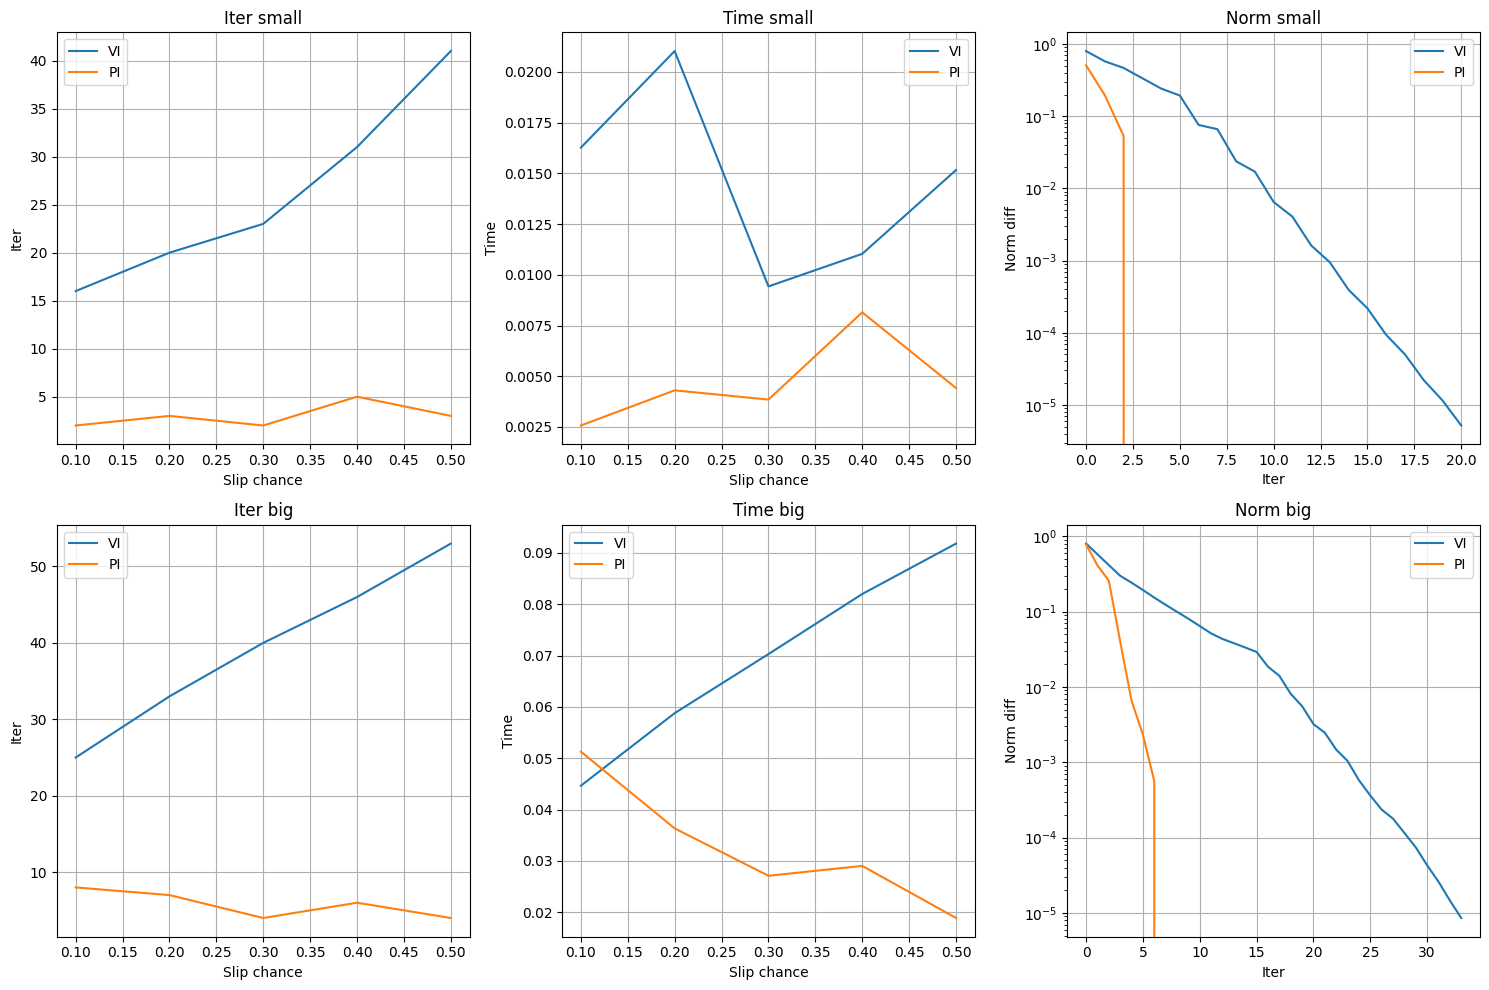

In [98]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(slip_chances, VI_iter_small, label='VI')
plt.plot(slip_chances, PI_iter_small, label='PI')
plt.xlabel('Slip chance')
plt.ylabel('Iter')
plt.title('Iter small')
plt.grid(True)
plt.legend()


plt.subplot(2, 3, 2)
plt.plot(slip_chances, VI_time_small, label='VI')
plt.plot(slip_chances, PI_time_small, label='PI')
plt.xlabel('Slip chance')
plt.ylabel('Time')
plt.title('Time small')
plt.grid(True)
plt.legend()


plt.subplot(2, 3, 3)
plt.plot(VI_diff_history_small, label='VI')
plt.plot(PI_diff_history_small, label='PI')
plt.xlabel('Iter')
plt.ylabel('Norm diff')
plt.title('Norm small')
plt.yscale('log')
plt.grid(True)
plt.legend()


plt.subplot(2, 3, 4)
plt.plot(slip_chances, VI_iter_big, label='VI')
plt.plot(slip_chances, PI_iter_big, label='PI')
plt.xlabel('Slip chance')
plt.ylabel('Iter')
plt.title('Iter big')
plt.grid(True)
plt.legend()


plt.subplot(2, 3, 5)
plt.plot(slip_chances, VI_time_big, label='VI')
plt.plot(slip_chances, PI_time_big, label='PI')
plt.xlabel('Slip chance')
plt.ylabel('Time')
plt.title('Time big')
plt.grid(True)
plt.legend()


plt.subplot(2, 3, 6)
plt.plot(VI_diff_history_big, label='VI')
plt.plot(PI_diff_history_big, label='PI')
plt.xlabel('Iter')
plt.ylabel('Norm diff')
plt.title('Norm big')
plt.yscale('log')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Вывод - асбсолютно по всем параметрам PI лучше VI.

# Поиск MDP, на котором Value Iteration работает достаточно долго <span style="color: green"> (до 2 баллов) </span>

Когда запускали Value Iteration на небольшой задаче frozen lake, последняя итерация, на которой изменялась стратегия обучаемой политики, была под номером 6 &mdash; то есть Value Iteration находил оптимальную политику на итерации 6. Существуют ли какие-либо гарантии на то, что в общем случае поиск оптимальной политики сверху ограничен конечным числом в MDP с негораниченным горизонтом с дисконтированием? Ответ без дополнительных предположений отрицательный, более того, можно предложить пример MDP, в котором жадный алгоритм оптимизации политики будет работать произвольное наперёд заданное заданное количество итераций.

Ваша задача: предъявить MDP с не более чем 3 состояниями и 2 действиями такой, что на нём алгоритм Value Iteration до останова требует, как минимум, 50 итераций. Используйте фактор дисконтирования, равный 0.95 (Однако, заметим, что величина дисконтирования тут не играет особой роли &mdash; в теории Вы можете предъявить MDP с произвольным дисконтированием, отвечающий требованиям выше.)

Замечание: Стратегия $\pi$ должна измениться хотя бы один раз после 50-ой итерации (включая 50-ую итерацию), не требуется изменение стратегии $\pi$ на каждой итерации.

In [334]:
transition_probs = {
    's0': {
        'fast': {'s2': 1.0},
        'slow': {'s1': 1.0}
    },
    's1': {
        'cycle': {'s1': 1.0}
    },
    's2': {}
}

rewards = {
    's0': {
        'fast': {'s2': +10},
        'slow': {'s1': 0}
    },
    's1': {
        'cycle': {'s1': +0.55}
    },
    's2': {}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')


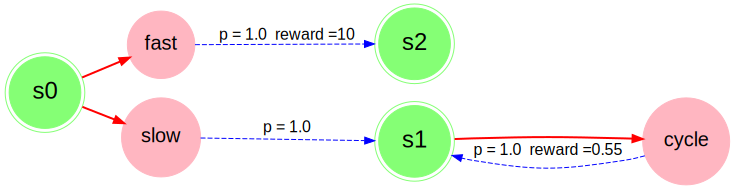

In [335]:
if has_graphviz:
    display(plot_graph(mdp))

In [337]:
%%time

gamma = 0.95
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("после итерации %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1, gamma=gamma)

    print(state_values)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    print(policy)
    print(new_policy)

    n_changes = (policy != new_policy).sum()
    print("Количество поменявшихся действий = %i \n" % n_changes)
    policy = new_policy

# просьба игнорировать отладочный вывод "Итерация 0" на каждом шаге

после итерации 0
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 10.00000   |   V(start): 10.000 
{'s0': 10.0, 's1': 0.55, 's2': 0}
['fast' 'cycle' None]
['fast' 'cycle' None]
Количество поменявшихся действий = 0 

после итерации 1
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.52250   |   V(start): 10.000 
{'s0': 10.0, 's1': 1.0725, 's2': 0}
['fast' 'cycle' None]
['fast' 'cycle' None]
Количество поменявшихся действий = 0 

после итерации 2
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.49638   |   V(start): 10.000 
{'s0': 10.0, 's1': 1.568875, 's2': 0}
['fast' 'cycle' None]
['fast' 'cycle' None]
Количество поменявшихся действий = 0 

после итерации 3
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.47156   |   V(start): 10.000 
{'s0': 10.0, 's1': 2.04043125, 's2': 0}
['fast' 'cycle' None]
['fast' 'cycle' None]
Количество поменявшихся действий = 0 

после итерации 4
Итерация    0   |   разность max_s|V_new(s) - V_old(s)|: 0.44798   |   V(start

Политика меняется на медленную на 61 шаге.